# Naive Bayes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

[nltk_data] Downloading package stopwords to /home/felix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/felix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# read data into pandas dataframe
#path = "data/video_games.tsv.gz"
#video_games = pd.read_csv(path, sep="\t", parse_dates=[14], on_bad_lines="skip")
train_balanced = pd.read_csv("data/balanced/train_balanced.csv")
val_balanced = pd.read_csv("data/balanced/val_balanced.csv")
train_stratified = pd.read_csv("data/stratified/train_stratified.csv")
val_stratified = pd.read_csv("data/stratified/val_stratified.csv")
test = pd.read_csv("data/test.csv")

display(train_balanced.head())
display(val_balanced.head())
display(train_stratified.head())
display(val_stratified.head())
display(test.head())

,full_review,star_rating
0,Only for Terminator enthusiasts I gave this ga...,2
1,Worked for a few months and the kids tore it ....,2
2,didnt work but received a full refund,2
3,Really good graphics for a game from 2005 Real...,4
4,was great until the band on top snapped in hal...,2


,full_review,star_rating
0,Works Good This product works good. It allows ...,5
1,The touch pad sucks on balls.,3
2,Not as good as Sniper Elite 2 (Xbox 360 versio...,3
3,"It's a turn based game, so don't expect a lot ...",2
4,Package came quickly and the game is great. T...,5


,index,full_review,star_rating
0,63042,Not working The CD is not working properly,2
1,40973,Awesome game.,5
2,330407,Do yourself a favor and by loose ones! Works g...,5
3,64545,Xbox live!! Xbox live!! We all know its the be...,5
4,293826,The kids love it. No complaints. The kids lov...,5


,index,full_review,star_rating
0,248410,Good Good,5
1,145340,It's awsome,5
2,201995,great works great use it every year,5
3,116305,Great game and with the extra tarot cards and ...,5
4,320353,The price was about the only thing good about...,3


,full_review,star_rating
0,"very fun game, good graphics and realistic dri...",5
1,Awesome Case I really like this case. When I w...,5
2,Great game,5
3,I ordered this by mistake thinking that I was ...,5
4,The game is very generic but fun my husband lo...,4


## Text Preprocessing

In [3]:
# functions used for preprocessing

def tokenize_words(text):
    tokenized_text = word_tokenize(text)
    return tokenized_text

def remove_punctuation(text):
    text = str(text)
    punctiations = string.punctuation
    return text.translate(str.maketrans('', '', punctiations))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(plain_text):
    return ' '.join([word for word in plain_text.split() if word not in STOPWORDS])

def remove_spec_char(text):
    text = str(text)
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

#lemmatizer = WordNetLemmatizer()
#wordnet_map = {'N':wordnet.NOUN, 'V':wordnet.VERB, 'J':wordnet.ADJ, 'R':wordnet.ADV}
#def lemmatize_word(plain_text):
#    # Finind pos tags
#    pos_text = pos_tag(plain_text.split())
#    return ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_text])

ps = PorterStemmer()
def stem_words(text):
    return ' '.join([ps.stem(word) for word in text.split()])


In [4]:
# lowercase words
train_balanced["full_review"] = train_balanced["full_review"].str.lower()
val_balanced["full_review"] = val_balanced["full_review"].str.lower()
train_stratified["full_review"] = train_stratified["full_review"].str.lower()
val_stratified["full_review"] = val_stratified["full_review"].str.lower()
test["full_review"] = test["full_review"].str.lower()
# remove punctuation,...
train_balanced["full_review"] = train_balanced["full_review"].apply(remove_punctuation)
val_balanced["full_review"] = val_balanced["full_review"].apply(remove_punctuation)
train_stratified["full_review"] = train_stratified["full_review"].apply(remove_punctuation)
val_stratified["full_review"] = val_stratified["full_review"].apply(remove_punctuation)
test["full_review"] = test["full_review"].apply(remove_punctuation)
# ...special characters,...
train_balanced["full_review"] = train_balanced["full_review"].apply(remove_spec_char)
val_balanced["full_review"] = val_balanced["full_review"].apply(remove_spec_char)
train_stratified["full_review"] = train_stratified["full_review"].apply(remove_spec_char)
val_stratified["full_review"] = val_stratified["full_review"].apply(remove_spec_char)
test["full_review"] = test["full_review"].apply(remove_spec_char)
# ...and stopwords
train_balanced["full_review"] = train_balanced["full_review"].apply(remove_stopwords)
val_balanced["full_review"] = val_balanced["full_review"].apply(remove_stopwords)
train_stratified["full_review"] = train_stratified["full_review"].apply(remove_stopwords)
val_stratified["full_review"] = val_stratified["full_review"].apply(remove_stopwords)
test["full_review"] = test["full_review"].apply(remove_stopwords)
# apply stemming
train_balanced["full_review"] = train_balanced["full_review"].apply(stem_words)
val_balanced["full_review"] = val_balanced["full_review"].apply(stem_words)
train_stratified["full_review"] = train_stratified["full_review"].apply(stem_words)
val_stratified["full_review"] = val_stratified["full_review"].apply(stem_words)
test["full_review"] = test["full_review"].apply(stem_words)

display(train_balanced.head())
display(val_balanced.head())
display(train_stratified.head())
display(val_stratified.head())
display(test.head())

,full_review,star_rating
0,termin enthusiast gave game 2 star like termin...,2
1,work month kid tore work month kid tore wire g...,2
2,didnt work receiv full refund,2
3,realli good graphic game 2005 realli good grap...,4
4,great band top snap half great band top snap h...,2


,full_review,star_rating
0,work good product work good allow play donkey ...,5
1,touch pad suck ball,3
2,good sniper elit 2 xbox 360 version fun somewh...,3
3,turn base game dont expect lot intens action v...,2
4,packag came quickli game great three sli game ...,5


,index,full_review,star_rating
0,63042,work cd work properli,2
1,40973,awesom game,5
2,330407,favor loos one work great made son happi get r...,5
3,64545,xbox live xbox live know best market price che...,5
4,293826,kid love complaint kid love,5


,index,full_review,star_rating
0,248410,good good,5
1,145340,awsom,5
2,201995,great work great use everi year,5
3,116305,great game extra tarot card inflat great game ...,5
4,320353,price thing good game first similar past game ...,3


,full_review,star_rating
0,fun game good graphic realist drive fun game g...,5
1,awesom case realli like case look one want cle...,5
2,great game,5
3,order mistak think get order mistak think get ...,5
4,game gener fun husband love dc univers love ga...,4


In [5]:
# prediction target
y_train_b = train_balanced["star_rating"].values
y_val_b = val_balanced["star_rating"].values
y_train_s = train_stratified["star_rating"].values
y_val_s = val_stratified["star_rating"].values
y_test = test["star_rating"].values

## Feature generation

### Binary word occurence vectors

In [6]:
# binary word occurence vectors
binary_vectorizer_b = CountVectorizer(binary=True)
binary_vectorizer_s = CountVectorizer(binary=True)

X_train_binary_b = binary_vectorizer_b.fit_transform(train_balanced["full_review"])
X_val_binary_b = binary_vectorizer_b.transform(val_balanced["full_review"])
X_test_binary_b = binary_vectorizer_b.transform(test["full_review"])

X_train_binary_s = binary_vectorizer_s.fit_transform(train_stratified["full_review"])
X_val_binary_s = binary_vectorizer_s.transform(val_stratified["full_review"])
X_test_binary_s = binary_vectorizer_s.transform(test["full_review"])

print(f"number of terms (balanced data set): {len(binary_vectorizer_b.get_feature_names_out())}")
print(f"number of terms (stratified data set): {len(binary_vectorizer_s.get_feature_names_out())}")

number of terms (balanced data set): 24681
number of terms (stratified data set): 19451


### TF-IDF vectors

In [7]:
# if-idf vectors
tfidf_vectorizer_b = TfidfVectorizer()
tfidf_vectorizer_s = TfidfVectorizer()

X_train_tfidf_b = tfidf_vectorizer_b.fit_transform(train_balanced["full_review"])
X_val_tfidf_b = tfidf_vectorizer_b.transform(val_balanced["full_review"])
X_test_tfidf_b = tfidf_vectorizer_b.transform(test["full_review"])

X_train_tfidf_s = tfidf_vectorizer_s.fit_transform(train_stratified["full_review"])
X_val_tfidf_s = tfidf_vectorizer_s.transform(val_stratified["full_review"])
X_test_tfidf_s = tfidf_vectorizer_s.transform(test["full_review"])

print(f"number of terms (balanced data set): {len(tfidf_vectorizer_b.get_feature_names_out())}")
print(f"number of terms (stratified data set): {len(tfidf_vectorizer_s.get_feature_names_out())}")

number of terms (balanced data set): 24681
number of terms (stratified data set): 19451


## Naive Bayes Model

Four different models are created:

- **nb_binary_b**: trained on binary word occurence vectors created from balanced dataset
- **nb_tfidf_b**: trained on tfidf vectors created from balanced dataset
- **nb_binary_s**: trained on binary word occurence vectors created from stratified dataset
- **nb_tfidf_s**: trained on tfidf vectors created from stratified dataset

In [8]:
model_configs = {
    "nb_binary_b": {"train_datasets": [X_train_binary_b, y_train_b], "val_datasets": [X_val_binary_b, y_val_b], "test_datasets": [X_test_binary_b, y_test], "alpha": None},
    "nb_tfidf_b": {"train_datasets": [X_train_tfidf_b, y_train_b], "val_datasets": [X_val_tfidf_b, y_val_b], "test_datasets": [X_test_tfidf_b, y_test], "alpha": None},
    "nb_binary_s": {"train_datasets": [X_train_binary_s, y_train_s], "val_datasets": [X_val_binary_s, y_val_s], "test_datasets": [X_test_binary_s, y_test], "alpha": None},
    "nb_tfidf_s": {"train_datasets": [X_train_tfidf_s, y_train_s], "val_datasets": [X_val_tfidf_s, y_val_s], "test_datasets": [X_test_tfidf_s, y_test], "alpha": None},
}

### Hyperparameter Tuning

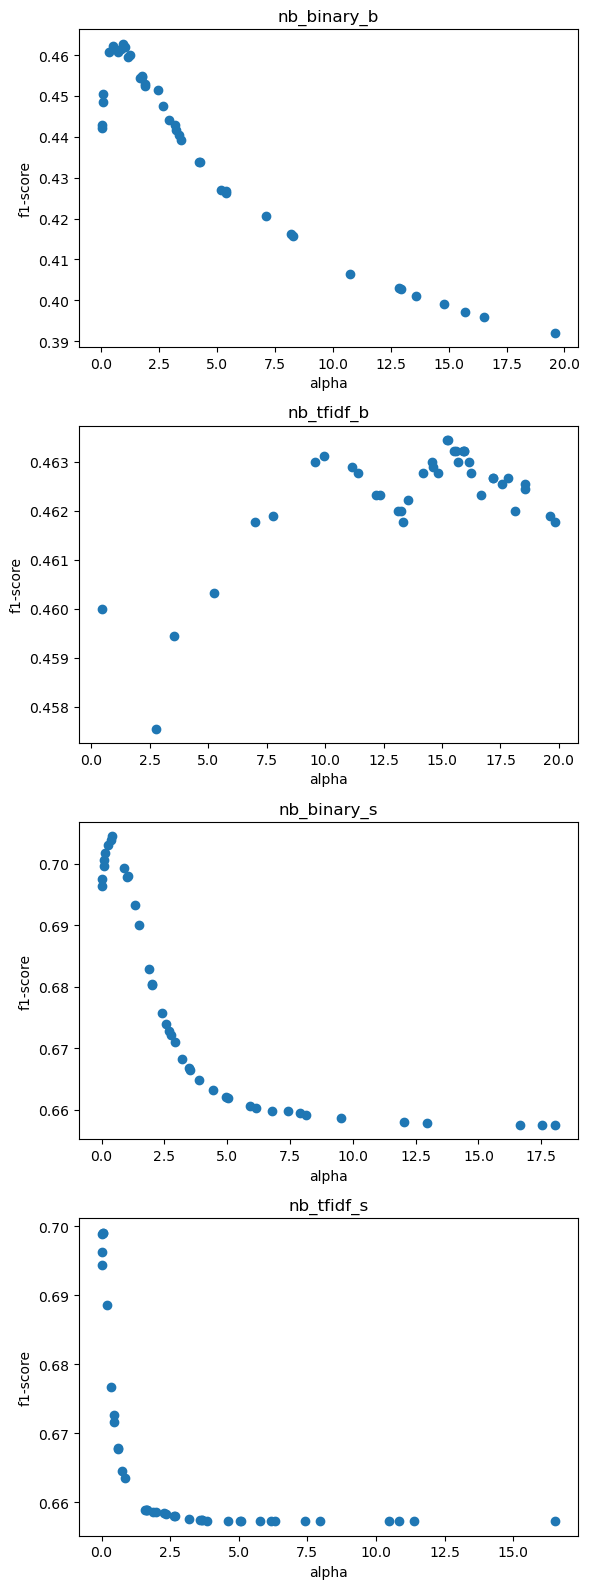

In [9]:
fig, axs = plt.subplots(nrows=4, tight_layout=True, figsize=(6, 16))

# iterate over different model configurations
for i, (model_name, model_config) in enumerate(model_configs.items()):

    # optimize hyperparameter alpha
    def objective(trial):
        # initiate model with alpha suggestion by optuna
        nb = MultinomialNB(alpha=trial.suggest_float("alpha", 0.0, 20.0))
        # fit model
        X_train = model_config["train_datasets"][0]
        y_train = model_config["train_datasets"][1]
        nb.fit(X_train, y_train)
        # evaluate model on validation set
        X_val = model_config["val_datasets"][0]
        y_val = model_config["val_datasets"][1]
        y_pred = nb.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="micro")
        return f1

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40)
    # best alpha value
    optimal_alpha = study.best_trial.params["alpha"]
    model_configs[model_name]["alpha"] = optimal_alpha
    # plot alpha values and f1-scores
    axs[i].scatter([trial.params["alpha"] for trial in study.trials], [trial.value for trial in study.trials])
    axs[i].set_title(model_name)
    axs[i].set_xlabel("alpha")
    axs[i].set_ylabel("f1-score")

### Model Evaluation

In [10]:
for model_name, model_config in model_configs.items():
    # build model
    alpha = model_config["alpha"]
    nb = MultinomialNB(alpha=alpha)
    # fit model
    X_train = model_config["train_datasets"][0]
    y_train = model_config["train_datasets"][1]
    nb.fit(X_train, y_train)
    # evaluate model on test set
    X_test = model_config["test_datasets"][0]
    y_test = model_config["test_datasets"][1]
    y_pred = nb.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="micro")
    print(f"f1-score {model_name} (alpha={alpha}): {f1}")
    print(classification_report(y_test, y_pred))

f1-score nb_binary_b (alpha=0.9454515346173122): 0.557815606436915
              precision    recall  f1-score   support

           1       0.49      0.67      0.56     15453
           2       0.15      0.38      0.22      6680
           3       0.20      0.32      0.25     11173
           4       0.23      0.34      0.28     22197
           5       0.89      0.62      0.73    109980

    accuracy                           0.56    165483
   macro avg       0.39      0.47      0.41    165483
weighted avg       0.69      0.56      0.60    165483

f1-score nb_tfidf_b (alpha=15.241588178407541): 0.4986796226802753
              precision    recall  f1-score   support

           1       0.55      0.57      0.56     15453
           2       0.12      0.56      0.20      6680
           3       0.19      0.31      0.23     11173
           4       0.21      0.35      0.26     22197
           5       0.91      0.53      0.67    109980

    accuracy                           0.50    1654

In [11]:
# baseline for comparison
# (predict 5 stars for every review)
print(f"f1-score baseline: {f1_score(y_test, [5 for _ in range(len(y_test))], average='micro')}")

f1-score baseline: 0.6645999891227498
